In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib

from hw1 import *

In [3]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
wd="/mnt/Backups/jmhu"

data_dir=wd+"/git_dirs/ComplexSystems_AMATH563/data/"
model_dir=wd+"/git_dirs/ComplexSystems_AMATH563/models/"
fig_dir = wd+"/git_dirs/ComplexSystems_AMATH563/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

## Load data

In [4]:
with open(data_dir+"pickled_mnist.pkl", 'rb') as f:
    trainX, testX, trainY, testY = pickle.load(f)

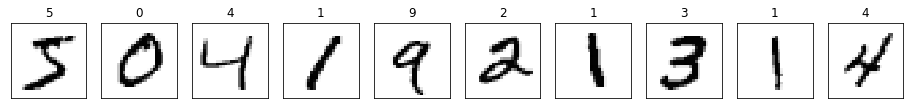

In [5]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY[i])

---

## Reassign matrix names

In [6]:
# A is the vectorized MNIST training images
A=trainX.copy()
print(A.shape)

# B is the set of output vectors
B=trainY.copy()
print(B.shape)

(60000, 784)
(60000,)


## Normalize data

In [7]:
print(A.min(), A.max())

scaler = StandardScaler()

A = scaler.fit_transform(A)
testX = scaler.transform(testX)

B = np.array(B)
testY = np.array(testY)

print(A.min(), A.max())

0 255
-1.2742078920822268 244.94693302873063


### Question 1.
Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

**Approach:** pick two solvers and vary regularization (guided by exploration runs)

In [8]:
solver_names = [
           "saga_elastic_L1_C01_mult", 
           "saga_elastic_L2_C01_mult",
           "saga_elastic_mix_C01_mult",
           "saga_elastic_half_C01_mult",
           "sgd_elastic_L2_C0005_mult"
          ]

In [10]:
%%time
n_jobs=4
tol=0.01

solvers=[]
l1_ratio = [1, 0, 0.8, 0.5]
multi_class="multinomial"

# saga + varying penalties
# with stochastic average gradient descent and L2 regularization

for i, model in enumerate(solver_names):
    if i+1 < (len(solver_names)):
        model=LogisticRegression(solver="saga", 
                                 multi_class=multi_class, 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=l1_ratio[i],
                                 n_jobs=n_jobs, 
                                 tol=tol)
    else:
        model=LogisticRegression(solver="sag", 
                                 multi_class=multi_class, 
                                 C=0.005, 
                                 penalty="l2", 
                                 n_jobs=n_jobs, 
                                 tol=tol)

    solvers.append(model)

CPU times: user 21 µs, sys: 10 µs, total: 31 µs
Wall time: 34.6 µs


In [11]:
solvers

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=1, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    war

## Test times without cross-validation

0
Model exists and loaded
Saving as hw1_cmsaga_elastic_L1_C01_mult.png
1
Model exists and loaded
Saving as hw1_cmsaga_elastic_L2_C01_mult.png
2
Model exists and loaded
Saving as hw1_cmsaga_elastic_mix_C01_mult.png
3
Model exists and loaded
Saving as hw1_cmsaga_elastic_half_C01_mult.png
4
Model exists and loaded
Saving as hw1_cmsgd_elastic_L2_C0005_mult.png


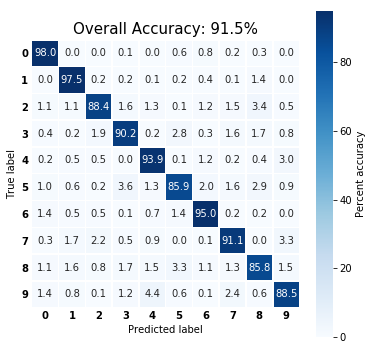

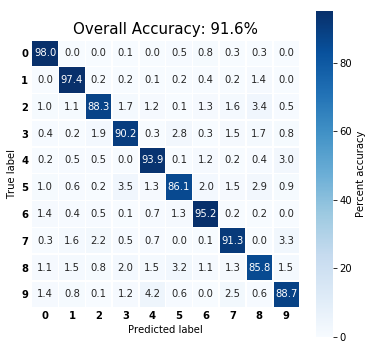

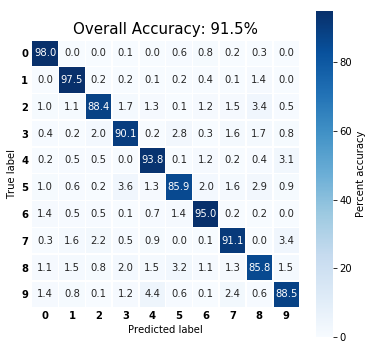

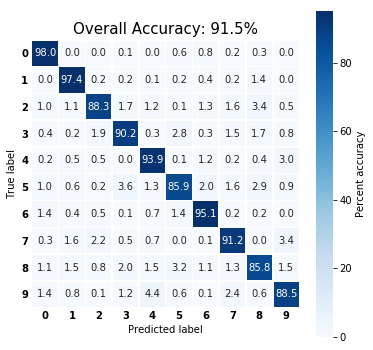

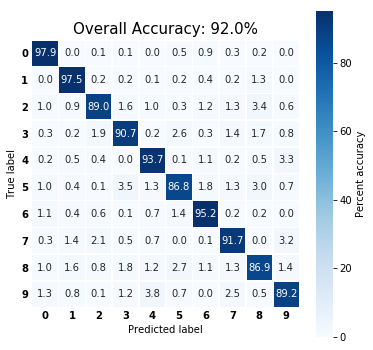

In [609]:
import time

models = []

# arrays will be arranged with different solutions in columns
preds = np.zeros((len(testX), len(solver_names)))
accs = np.zeros((len(solver_names)))
reports = []
matrices = np.zeros((10, 10*len(solver_names)))

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    print(i)
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred = trained_model.predict(testX)
        acc = trained_model.score(testX, testY)
        
        print("Model exists and loaded")
        
    else:
        start=time.time()
        trained_model, pred, acc = optimize(model, A, B, testX, testY)  
        print("{0:.2f}".format(time.time()-start), "sec elapsed")

        print(model_name, "trained")
        
        joblib.dump(model, model_fn)

    models.append(trained_model)
    preds[:, i] = pred
    accs[i] = acc
    
    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices[:, 10*i : 10*i + 10] = m
    reports.append(r)

    fig_name = fig_dir+"hw1_cm" + model_name + ".png"

    plot_confusion(m, acc, save_fn = fig_name)

### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling. 

In [879]:
%%time

# Use important pixels as training matrix
A = trainX
B = trainY

model=Lasso(tol=tol)
model_name="lasso"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

joblib.dump(trained_model, model_fn)

1.74 sec elapsed
CPU times: user 18.4 s, sys: 7.74 s, total: 26.2 s
Wall time: 1.74 s


In [881]:
trained_model

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

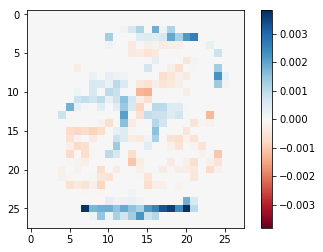

In [884]:
clim=max(np.abs(A_lasso.min()), np.abs(A_lasso.max()))
plt.imshow(A_lasso.reshape(28,28), vmin=-clim, vmax=clim, cmap="RdBu")
plt.colorbar()

#### Use L1 penalty to promote sparsity
LASSO uses L1 norm as constraint to promote sparsity



# Use logistic regression model relying on non-zero LASSO coefficient pixels as mask for training data

In [886]:
model = models[2]
model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                   multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

In [ ]:
%%time

# Use important pixels as training matrix
A = trainX
B = trainY

model=Lasso(tol=tol)
model_name="lasso"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

joblib.dump(trained_model, model_fn)

In [611]:
# Check sparsity of coefficients
sparsity_L1 = np.mean(models[0].coef_ == 0)*100
sparsity_L2 = np.mean(models[1].coef_ == 0)*100
sparsity_mix = np.mean(models[2].coef_ == 0)*100
sparsity_half = np.mean(models[3].coef_ == 0)*100

print("Sparsity with L1 penalty:", sparsity_L1)
print("Sparsity with L2 penalty:", sparsity_L2)
print("Sparsity with 0.8 L1 ratio penalty:", sparsity_mix)
print("Sparsity with 0.5 L1 ratio penalty:", sparsity_half)

Sparsity with L1 penalty: 23.941326530612244
Sparsity with L2 penalty: 8.545918367346939
Sparsity with 0.8 L1 ratio penalty: 22.831632653061224
Sparsity with 0.5 L1 ratio penalty: 18.8265306122449


In [612]:
# Rank pixels in single image to show most informative for digit labelling

In [613]:
solver_names

['saga_elastic_L1_C01_mult',
 'saga_elastic_L2_C01_mult',
 'saga_elastic_mix_C01_mult',
 'saga_elastic_half_C01_mult',
 'sgd_elastic_L2_C0005_mult']

In [624]:
m_index=2
thisModel = models[m_index]
coef=thisModel.coef_

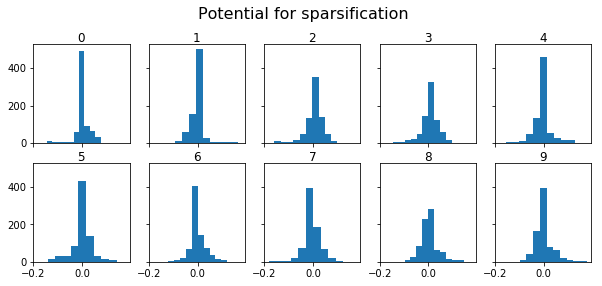

In [625]:
hist_coef(thisModel)

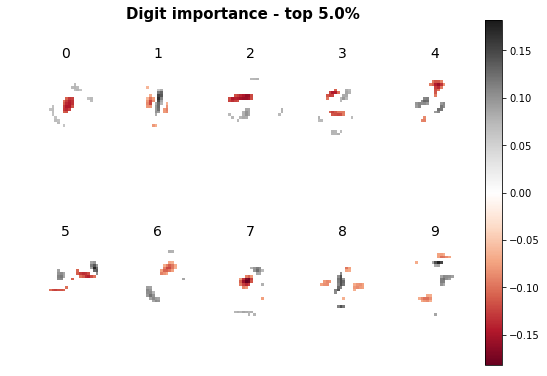

In [626]:
plot_vip(thisModel)

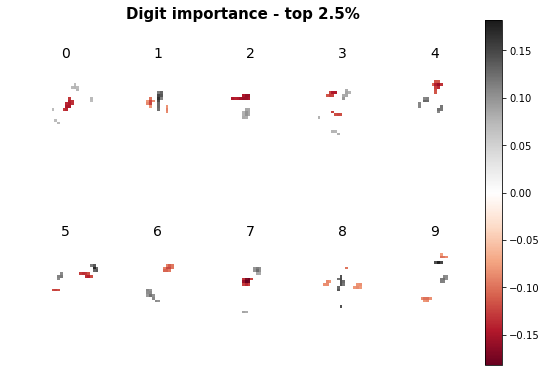

In [627]:
plot_vip(thisModel, p=1.25)

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

Extract new training imagery of these most important pixels

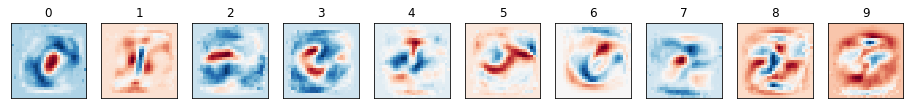

In [629]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = coef[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)

0


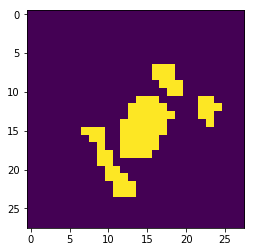

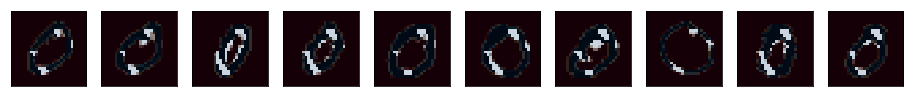

1


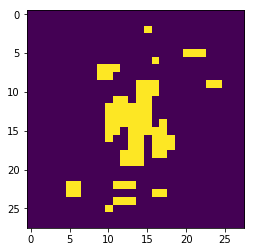

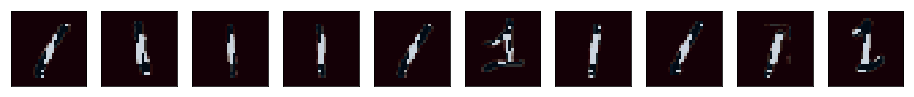

2


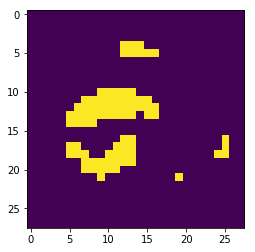

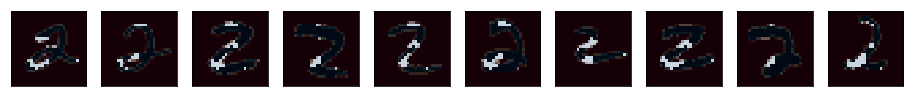

3


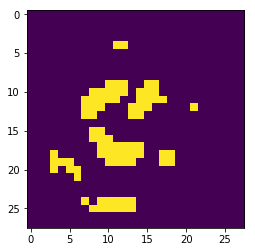

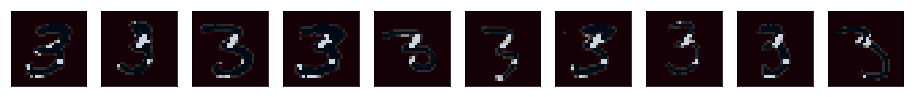

4


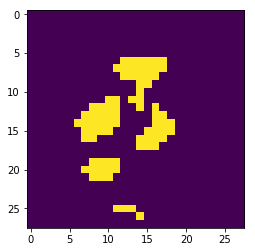

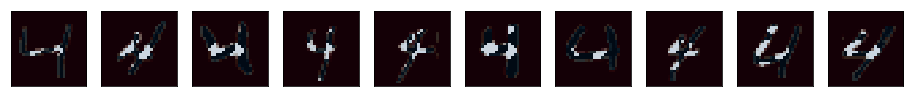

5


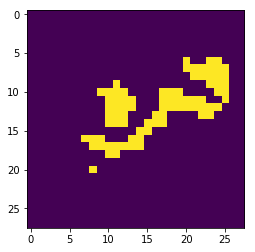

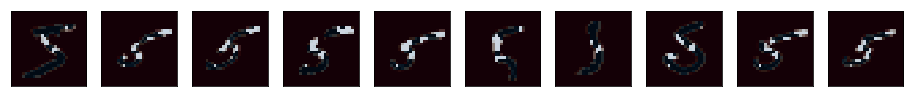

6


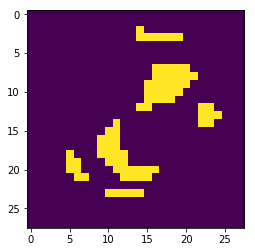

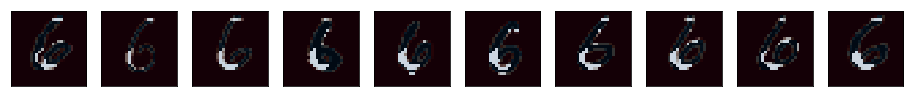

7


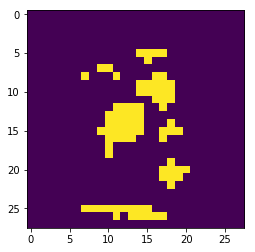

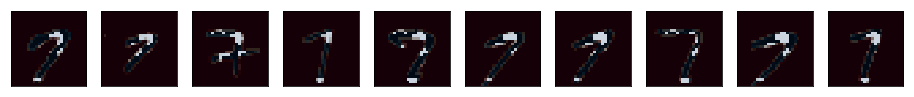

8


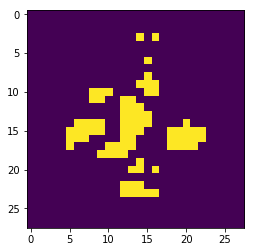

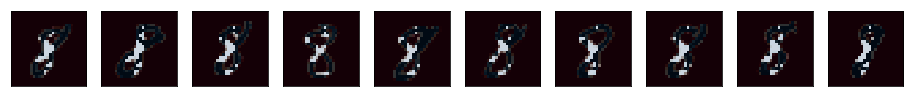

9


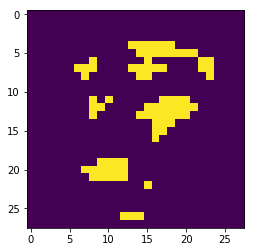

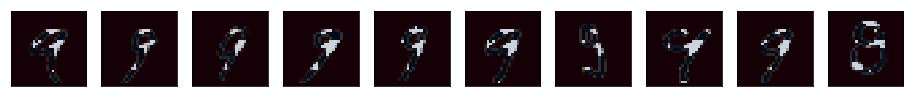

In [638]:
coef=thisModel.coef_

p=5
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

def fandr(in_img, indices):
    '''
    Return input image with only values at specified indices
    '''
    new_img=np.zeros_like(in_img)
    new_img[indices] = in_img[indices]
    return(new_img)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

Use these to train a new model

In [639]:
vip_digit_names

['saga_elastic_L1_C01_mult_vip_digit',
 'saga_elastic_L2_C01_mult_vip_digit',
 'saga_elastic_mix_C01_mult_vip_digit',
 'saga_elastic_half_C01_mult_vip_digit',
 'sgd_elastic_L2_C0005_mult_vip_digit']

0
1
2
77.42 sec elapsed
saga_elastic_mix_C01_mult_vip_digit trained
Saving as hw1_cmsaga_elastic_mix_C01_mult_vip_digit.png
3
4


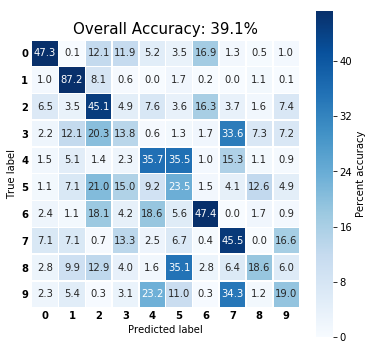

In [640]:
# Use important pixels as training matrix
A = new_trainX_digits

vip_digit_names=[s+"_vip_digit" for s in solver_names]

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, vip_digit_names)):
    print(i)
    if i != 2:
        pass
    else:
        model_fn=model_dir + model_name + ".pkl"

        if os.path.exists(model_fn):
            trained_model = joblib.load(model_fn)
            print("Model exists and loaded")

        else:
            start=time.time()
            trained_model, pred, acc = optimize(model, A, B, testX, testY)  
            print("{0:.2f}".format(time.time()-start), "sec elapsed")

            print(model_name, "trained")

            joblib.dump(model, model_fn)

        r, m = compute_loss(trained_model, pred, testX, testY)
        fig_name = fig_dir + "hw1_cm" + model_name + ".png"
        plot_confusion(m, acc, save_fn = fig_name)

### Using 10% of pixels results in 39% accuracy. This is nearly a 50% drop

### Using 20% of pixels

0


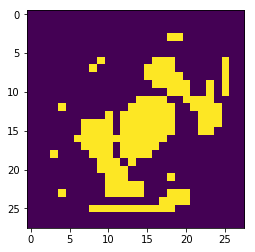

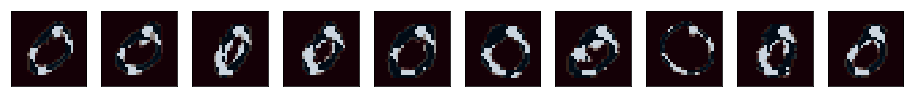

1


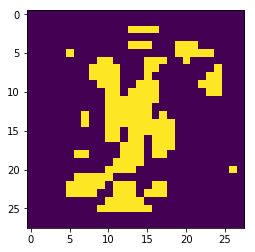

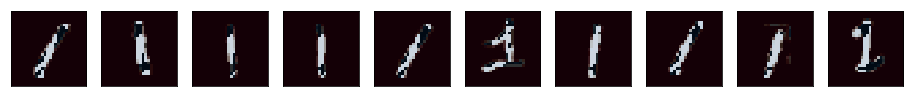

2


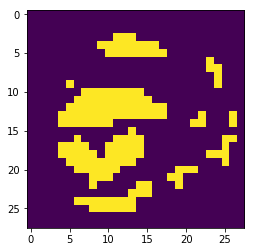

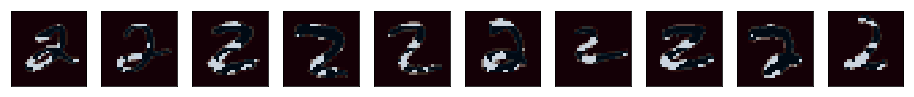

3


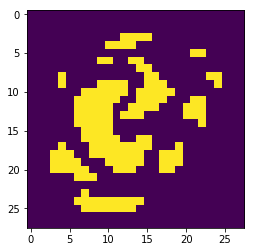

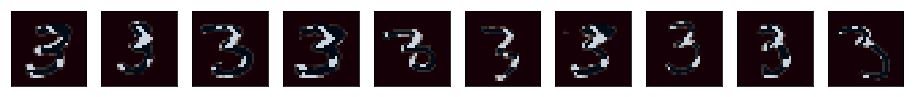

4


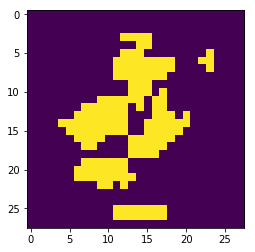

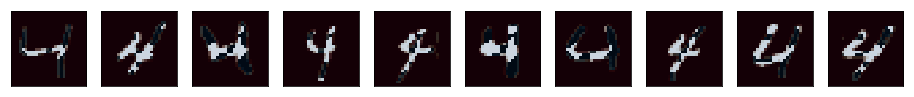

5


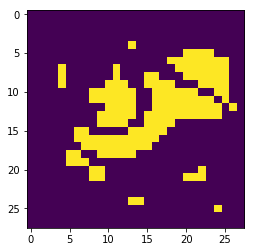

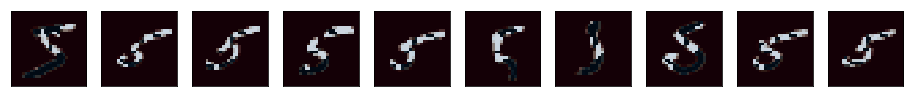

6


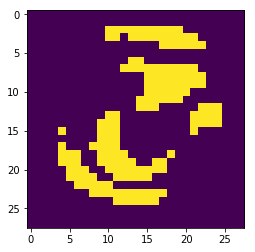

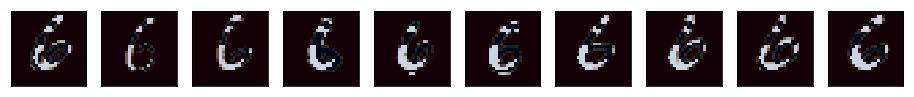

7


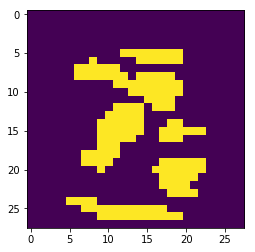

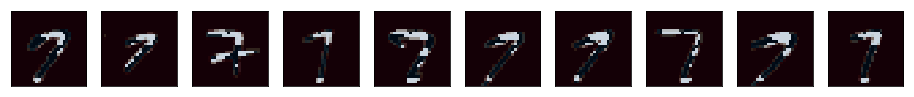

8


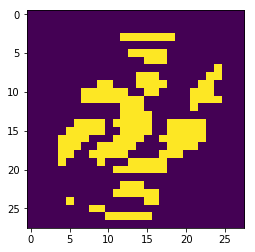

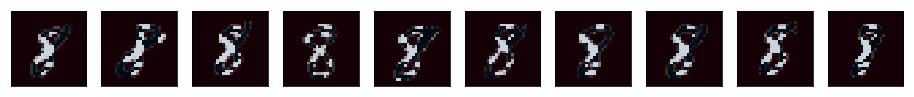

9


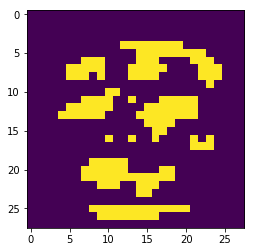

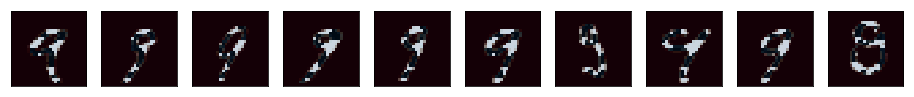

In [641]:
coef=thisModel.coef_

p=10
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

0
1
2
53.87 sec elapsed
saga_elastic_mix_C01_mult_vip_digit_20perc trained
Saving as hw1_cmsaga_elastic_mix_C01_mult_vip_digit_20perc.png
3
4


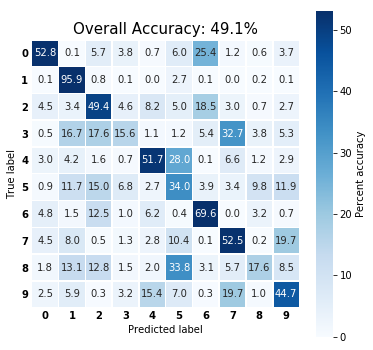

In [658]:
# Use important pixels as training matrix
A = new_trainX_digits

vip_digit_names=[s+"_vip_digit_20perc" for s in solver_names]

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, vip_digit_names)):
    print(i)
    if i != 2:
        pass
    else:
        model_fn=model_dir + model_name + ".pkl"

        if os.path.exists(model_fn):
            trained_model = joblib.load(model_fn)
            print("Model exists and loaded")

        else:
            start=time.time()
            trained_model, pred, acc = optimize(model, A, B, testX, testY)  
            print("{0:.2f}".format(time.time()-start), "sec elapsed")

            print(model_name, "trained")

            joblib.dump(model, model_fn)

        r, m = compute_loss(trained_model, pred, testX, testY)
        fig_name = fig_dir + "hw1_cm" + model_name + ".png"
        plot_confusion(m, acc, save_fn = fig_name)

### Using 20% of pixels results in 49% accuracy. This is almost a 40% drop

0


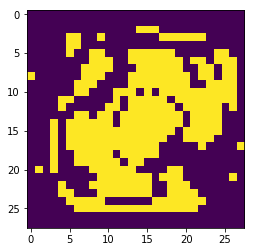

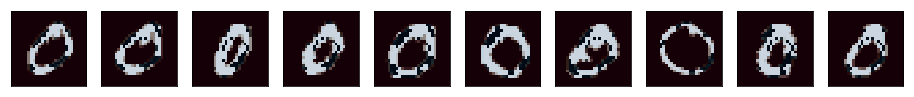

1


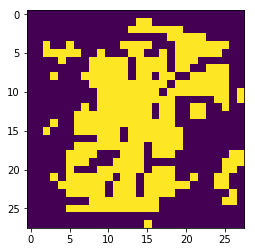

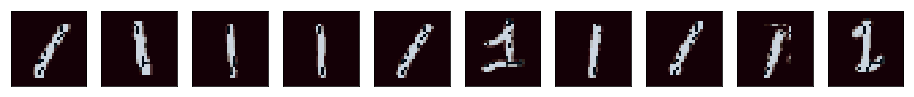

2


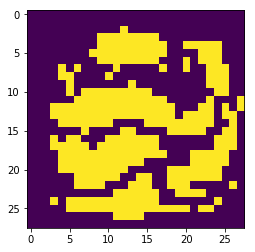

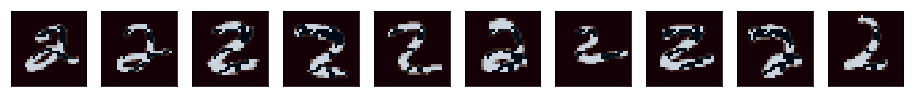

3


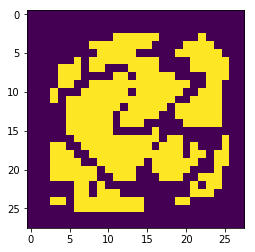

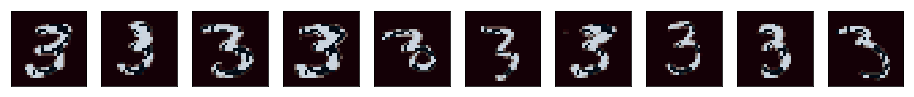

4


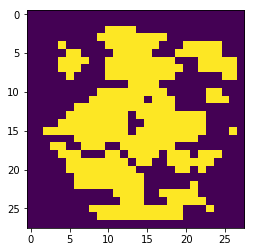

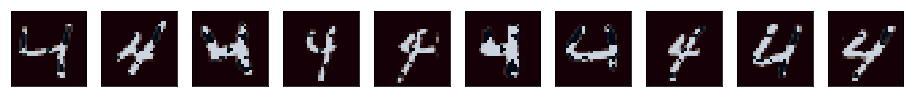

5


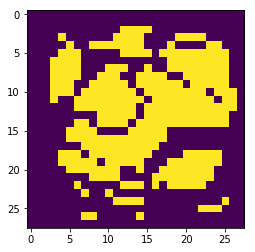

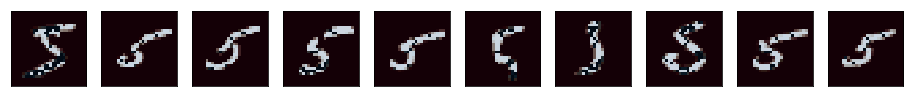

6


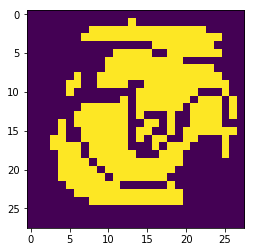

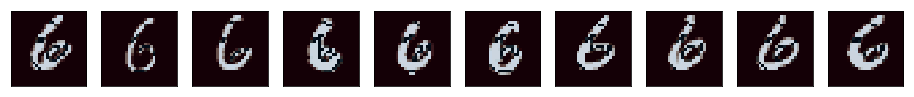

7


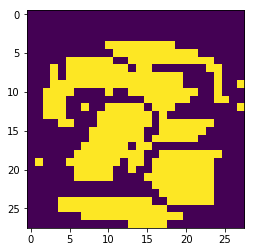

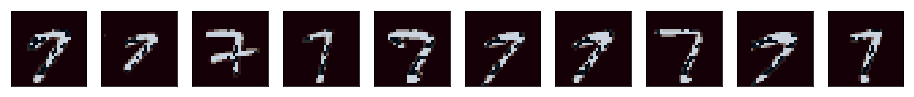

8


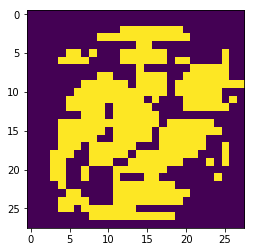

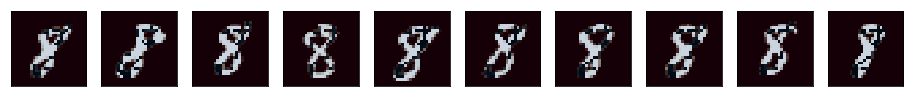

9


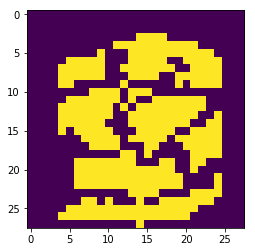

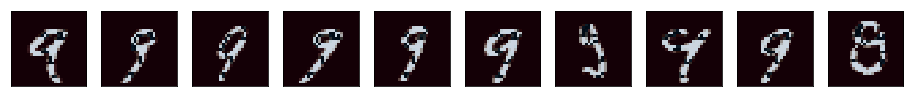

0
1
2
70.29 sec elapsed
saga_elastic_mix_C01_mult_vip_digit_40perc trained
Saving as hw1_cmsaga_elastic_mix_C01_mult_vip_digit_40perc.png
3
4


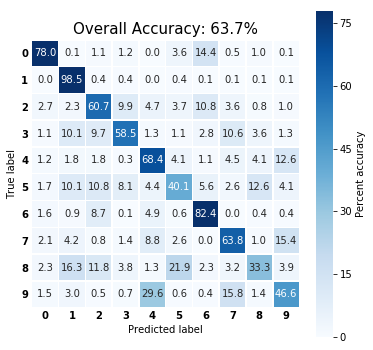

In [660]:
coef=thisModel.coef_

p=20
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use important pixels as training matrix
A = new_trainX_digits

vip_digit_names=[s+"_vip_digit_"+str(p*2)+"perc" for s in solver_names]

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, vip_digit_names)):
    print(i)
    if i != 2:
        pass
    else:
        model_fn=model_dir + model_name + ".pkl"

        if os.path.exists(model_fn):
            trained_model = joblib.load(model_fn)
            print("Model exists and loaded")

        else:
            start=time.time()
            trained_model, pred, acc = optimize(model, A, B, testX, testY)  
            print("{0:.2f}".format(time.time()-start), "sec elapsed")

            print(model_name, "trained")

            joblib.dump(model, model_fn)

        r, m = compute_loss(trained_model, pred, testX, testY)
        fig_name = fig_dir + "hw1_cm" + model_name + ".png"
        plot_confusion(m, acc, save_fn = fig_name)

### Using 40% of pixels results in 63.7% accuracy. This is almost a 30% drop

### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

79.36 sec elapsed
saga_elastic_mix_C01_ovr trained
Saving as hw1_cmsaga_elastic_mix_C01_ovr.png


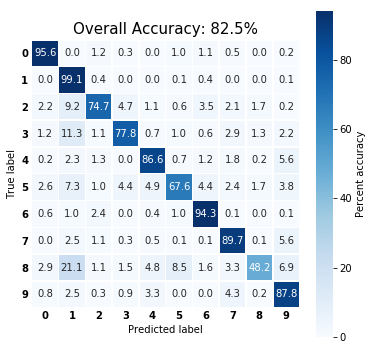

In [666]:
# Use important pixels as training matrix
A = trainX

model=LogisticRegression(solver="saga", 
                                 multi_class='ovr', 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=0.8,
                                 n_jobs=n_jobs, 
                                 tol=tol)
model_name="saga_elastic_mix_C01_ovr"

model_fn=model_dir + model_name + ".pkl"

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

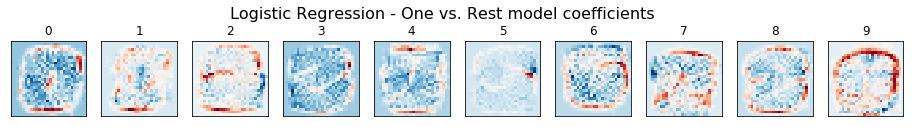

In [681]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = model.coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - One vs. Rest model coefficients", fontsize=16, y=0.75);

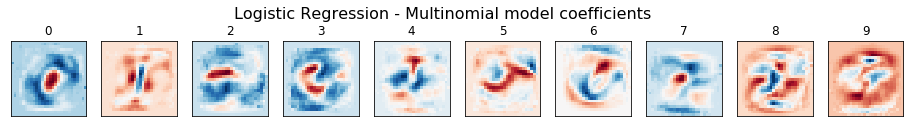

In [682]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = models[2].coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - Multinomial model coefficients", fontsize=16, y=0.75);

In [ ]:
# So how do you get a single most important pixel?
Take the average of the multinomial model coefficients

# Try simple network

Input is x (trainX, or what you've been calling "A")
Output is y (trainY, the labels, or what you've been calling "B")
y=function (matrix A of coefficients to get from one layer of x's to the next)
`y=Am*Am-1*...*A2*A1*x`

This is what you were doing above - how do you find the most important pixels?

Try this, with the first thousand of the train images for time

In [683]:
# Solve for A
Y=trainY.copy()
Y.shape

(60000,)

In [684]:
X=trainX.copy()
X.shape

(60000, 784)

In [876]:
%%time
# Use LASSO
lasso = Lasso(tol=tol).fit(X,Y)
A_lasso=lasso.coef_
test_labels_lasso = A_lasso @ testX.T

CPU times: user 17.6 s, sys: 7.92 s, total: 25.5 s
Wall time: 1.68 s


In [877]:
test_labels_lasso

array([ 0.03200751, -0.02418458, -0.03261629, ...,  0.03531983,
        0.00832702,  0.04237155])

In [843]:
%%time

# Use important pixels as training matrix
A = X
B = onehotlabels

model=Lasso(tol=tol)

model_name="lasso"

model_fn=model_dir + model_name + ".pkl"

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(model, model_fn)

# r, m = compute_loss(trained_model, pred, testX, testY)
# fig_name = fig_dir + "hw1_cm" + model_name + ".png"
# plot_confusion(m, acc, save_fn = fig_name)

Model exists and loaded
CPU times: user 1.54 ms, sys: 183 µs, total: 1.73 ms
Wall time: 1.32 ms


In [847]:
trained_model.coef_.shape


(784,)

In [828]:
print("Potential for sparsity = ", "{0:.1f}".format((A_lasso==0).sum()/784 * 100), "%")

Potential for sparsity =  69.9 %


In [829]:
# Extract pixel indices that are non-zero
lasso_inds=np.indices(A_lasso.shape).squeeze()
sparse_A_lasso = lasso_inds[A_lasso !=0]
sparse_A_lasso

array([ 68,  69,  70,  72,  73,  74,  94,  98,  99, 100, 101, 102, 103,
       104, 105, 122, 125, 127, 128, 129, 130, 131, 135, 153, 154, 155,
       156, 159, 164, 184, 188, 189, 202, 211, 214, 215, 217, 220, 232,
       234, 235, 236, 241, 242, 243, 244, 248, 249, 260, 261, 262, 263,
       264, 266, 267, 268, 269, 270, 271, 272, 276, 277, 286, 288, 290,
       291, 292, 294, 295, 297, 300, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 341, 342, 343, 345, 347, 348, 349, 350, 352, 353,
       354, 355, 356, 359, 368, 376, 378, 379, 380, 381, 382, 383, 384,
       387, 401, 402, 404, 405, 408, 409, 413, 414, 415, 425, 426, 427,
       428, 429, 431, 432, 433, 436, 440, 453, 454, 456, 459, 460, 461,
       462, 463, 464, 466, 467, 468, 469, 481, 482, 483, 487, 489, 491,
       493, 494, 495, 497, 498, 509, 511, 512, 514, 515, 517, 526, 528,
       537, 538, 539, 545, 546, 547, 549, 550, 551, 552, 553, 555, 556,
       564, 566, 569, 571, 574, 576, 577, 578, 579, 580, 581, 58

(60000, 784)


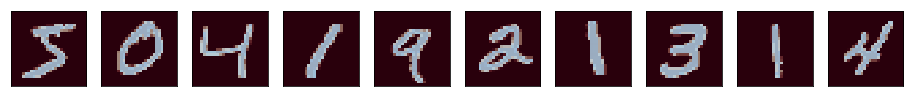

In [832]:
# Use indices to uniformly extract pixels from training X 
new_X=np.apply_along_axis(fandr, indices=lasso_inds, axis=1, arr=X)
print(new_X.shape)

plt.figure(figsize=(16,4))

for j in range(10):
    ax = plt.subplot(1, 10, j + 1)
    img = trainX[j].reshape((28,28))
    img2 = new_X[j].reshape((28,28))
    ax.imshow(img, cmap="RdBu")
    ax.imshow(img2, cmap="Greys_r", alpha=0.6)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [833]:
lasso

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

258.49 sec elapsed
lasso_sparse_saga_elastic_mix_C01_mult trained
Saving as hw1_cmlasso_sparse_saga_elastic_mix_C01_mult.png
CPU times: user 4min 20s, sys: 1.36 s, total: 4min 21s
Wall time: 4min 18s


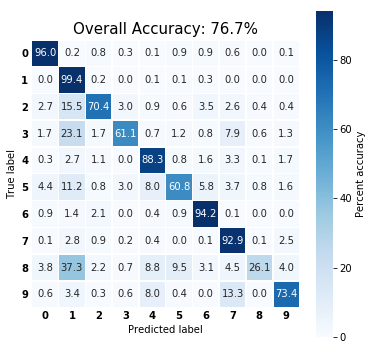

In [851]:
%%time
# Use important pixels as training matrix
A = new_X
B = Y

model=models[2]

model_name="lasso_sparse_saga_elastic_mix_C01_mult"

model_fn=model_dir + model_name + ".pkl"

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc = optimize(model, A, B, testX, testY)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print(model_name, "trained")

    joblib.dump(model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


In [ ]:
f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)
The way I've been doing this above has been using 10 different X's -- or a one vs. all approach 
see this https://towardsdatascience.com/kannada-visual-model-952cc6ec3a72 and this https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

Determine X using logistic regression specifying solvers, an error function, and regularization (constraints, penalties to tweak the function)
Use L1 norm where we minimize the average error (better performance with outliers than L2 norm)

Ranking most informative pixels

In [ ]:
# Convert labels to float type
train_labels = np.asfarray(trainY)
test_labels = np.asfarray(testY)


lr = np.arange(len(np.unique(test_labels)))

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels.reshape(60000,1)).astype(np.float)
test_labels_one_hot = (lr==test_labels.reshape(10000,1)).astype(np.float)

# we don't want zeroes and ones in the labels:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99